In [3]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
import fsps
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth
from spec_stats import Smooth, Highest_density_region
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [93]:
med,le,he = np.zeros([3,10])
for i in range(10):
    x,px = np.load('../data/posteriors/GND_21156_tabfit_Pm{0}.npy'.format(i+1))
    med[i],le[i],he[i] = Highest_density_region(px,x)

x,px = np.load('../data/posteriors/GND_21156_tabfit_Pa.npy')
a,ale,ahe = Highest_density_region(px,x)

time, sfr, tmax = convert_sfh(get_agebins(a), med, maxage = a*1E9)
time, sfr_l, tmax = convert_sfh(get_agebins(a), med - le, maxage = a*1E9)
time, sfr_h, tmax = convert_sfh(get_agebins(a), med + he, maxage = a*1E9)

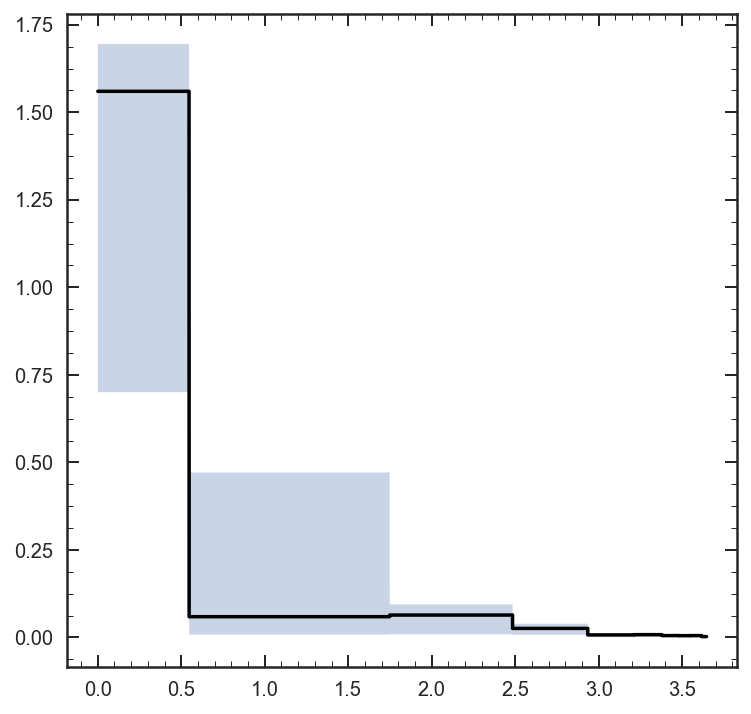

In [94]:
plt.figure(figsize=[6,6])
plt.plot(time,sfr,'k')
# plt.plot(time,sfr_l,'k')
# plt.plot(time,sfr_h,'k')
plt.fill_between(time,sfr_l, sfr_h, alpha = 0.3)


In [95]:
MB = [0]
T=[0]
m=0
IMB = []
for i in range(len(time)//2):
    m+=sfr[i*2+1] * (time[i*2+1] - time[i*2])
    IMB.append(sfr[i*2+1] * (time[i*2+1] - time[i*2]))
    MB.append(m)
    T.append(time[i*2+1])

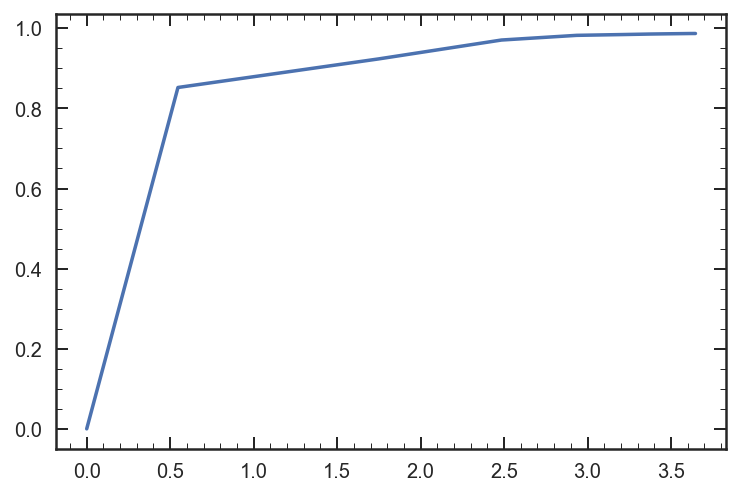

In [101]:
plt.plot(T,MB)

In [97]:
sum(IMB[1:])

0.13479114941362091

In [98]:
newx = np.arange(T[1],T[-1]+0.001,0.001)
tau = np.arange(0.001,1,0.001)

mass = []
for i in tau: 
    k = sfr[1] / max(np.exp(-newx / i))
    expfit = np.exp(-newx / i) * k
    mass.append(np.trapz(expfit,newx))
#     plt.plot(newx, expfit)
#     plt.plot(time,sfr ,'k')


array(0.08640263)

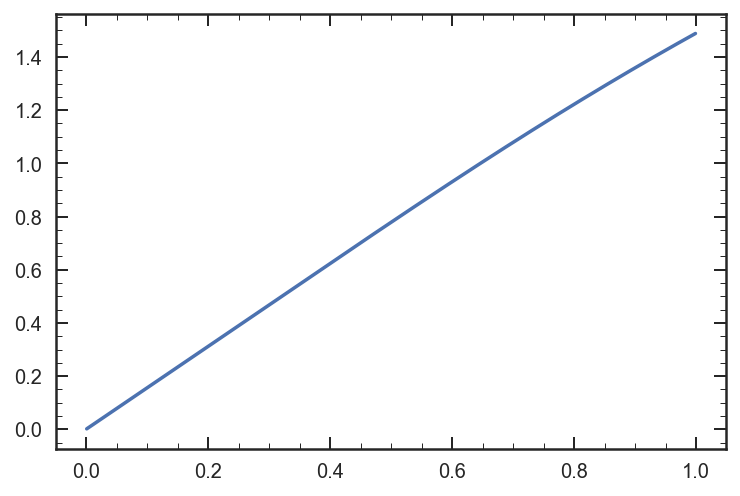

In [99]:
plt.plot(tau,mass)
interp1d(mass,tau)(sum(IMB[1:]))

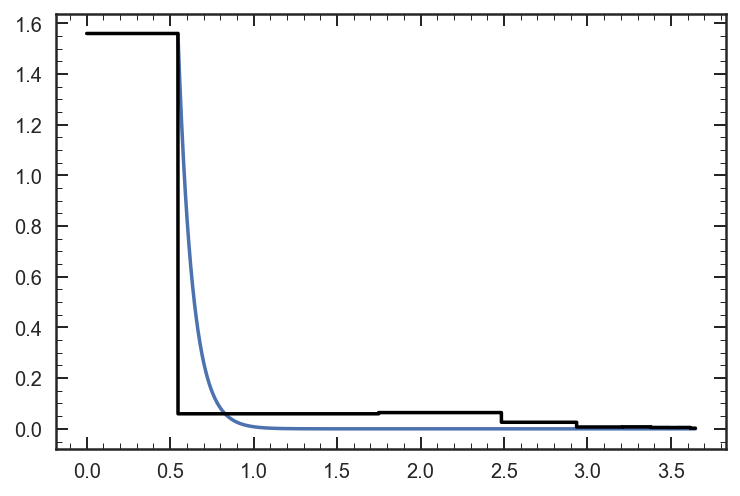

In [100]:
outtau = interp1d(mass,tau)(sum(IMB[1:]))
k = sfr[1] / max(np.exp(-newx /outtau))
expfit = np.exp(-newx / outtau) * k
plt.plot(newx, expfit)
plt.plot(time,sfr ,'k')

In [123]:
def Get_tau(field, galaxy):
    
    med = np.zeros(10)
    for i in range(10):
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pm{2}.npy'.format(field, galaxy, i+1))
        med[i] = x[px == px.max()][0]

    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pa.npy'.format(field, galaxy))
    a = x[px == px.max()][0]

    time, sfr, tmax = convert_sfh(get_agebins(a), med, maxage = a*1E9)
    
    T=[0]
    IMB = []
    for i in range(len(time)//2):
        IMB.append(sfr[i*2+1] * (time[i*2+1] - time[i*2]))
        T.append(time[i*2+1])
    
    newx = np.arange(T[1],T[-1]+0.001,0.001)
    tau = np.arange(0.001,1,0.001)

    mass = []
    for i in tau: 
        k = sfr[1] / max(np.exp(-newx / i))
        expfit = np.exp(-newx / i) * k
        mass.append(np.trapz(expfit,newx))

    return interp1d(mass,tau)(sum(IMB[1:]))


In [125]:
Get_tau('GSD',39170)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply


array(0.0020359)

# get size

In [103]:
goodss_rad = Table.read('/Users/vestrada/Downloads/allfields/goodss/goodss_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
goodsn_rad = Table.read('/Users/vestrada/Downloads/allfields/goodsn/goodsn_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
# goodss_rad = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodss_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
# goodsn_rad = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodsn_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()

In [105]:
flist = glob('../data/posteriors/*zfit*')

fld = [os.path.basename(U).split('_')[0] for U in flist] 
ids = np.array([os.path.basename(U).split('_')[1] for U in flist]).astype(int)

In [127]:
Reff = []
taus = []
rshift = []

for i in range(len(fld)):
    try:
        taus.append(Get_tau(fld[i],ids[i]))
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pz.npy'.format(fld[i], ids[i]))
        rshift.append(x[px==px.max()][0])

        if fld[i][1] == 'S':
            r = goodss_rad.re[goodss_rad.NUMBER == ids[i]].values * np.sqrt(goodss_rad.q[goodss_rad.NUMBER == ids[i]].values)
            Reff.append(r[0])
        if fld[i][1] == 'N':
            r = goodsn_rad.re[goodsn_rad.NUMBER == ids[i]].values * np.sqrt(goodsn_rad.q[goodsn_rad.NUMBER == ids[i]].values)
            Reff.append(r[0])
    except:
        print('skip {0}_{1}'.format(fld[i], ids[i]))


    

skip GND_12078
skip GND_12793


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply


skip GND_13182
skip GND_13774
skip GND_14713
skip GND_16758


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in double_scalars


skip GND_17070
skip GND_17194
skip GND_17436
skip GND_22213
skip GND_23081
skip GND_23459
skip GND_23490
skip GND_23631
skip GND_23758
skip GND_24177
skip GND_26673
skip GND_27458
skip GND_27951
skip GND_30358
skip GND_32108
skip GND_33453
skip GND_36102
skip GND_36348
skip GND_37180
skip GND_37189
skip GND_37210
skip GND_37232
skip GND_37340
skip GND_37686
skip GND_37955
skip GSD_18642
skip GSD_19148
skip GSD_23421
skip GSD_38472
skip GSD_38785
skip GSD_39241
skip GSD_39631
skip GSD_39805
skip GSD_40476
skip GSD_40597
skip GSD_40623
skip GSD_41886
skip GSD_42113
skip GSD_44042
skip GSD_44620
skip GSD_45775
skip GSD_45972
skip GSD_47223
skip GSD_47677
skip GSD_47691


In [137]:
taus = np.array(taus)
Reff = np.array(Reff)
rshift = np.array(rshift)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


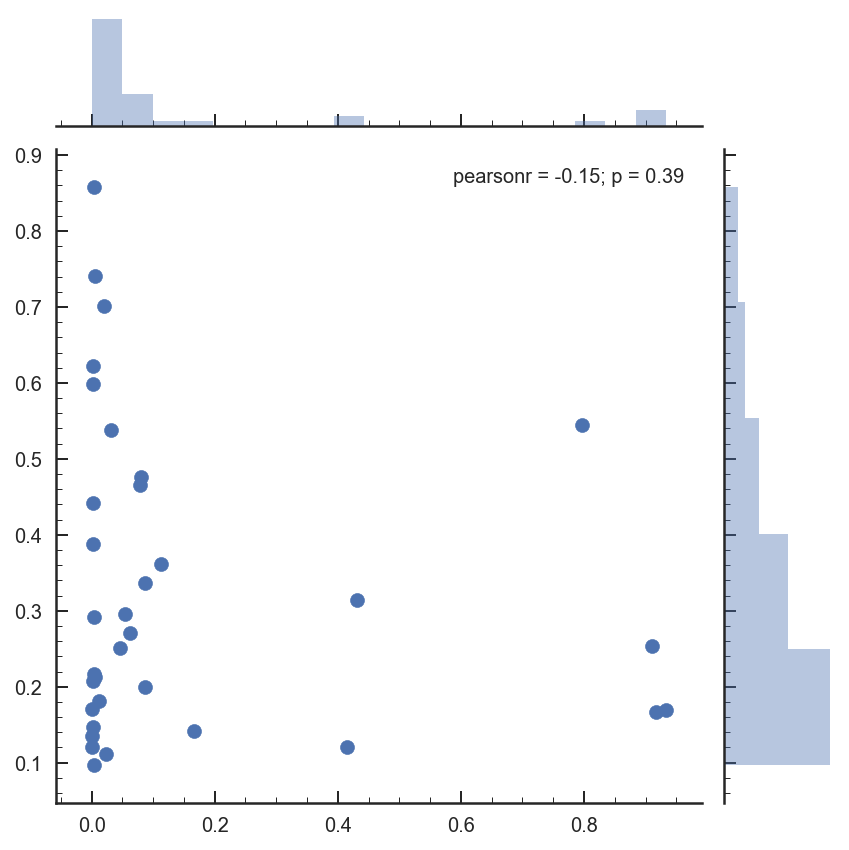

In [136]:
sea.jointplot(taus[Reff < 2],Reff[Reff < 2])
# plt.ylim(0,1)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


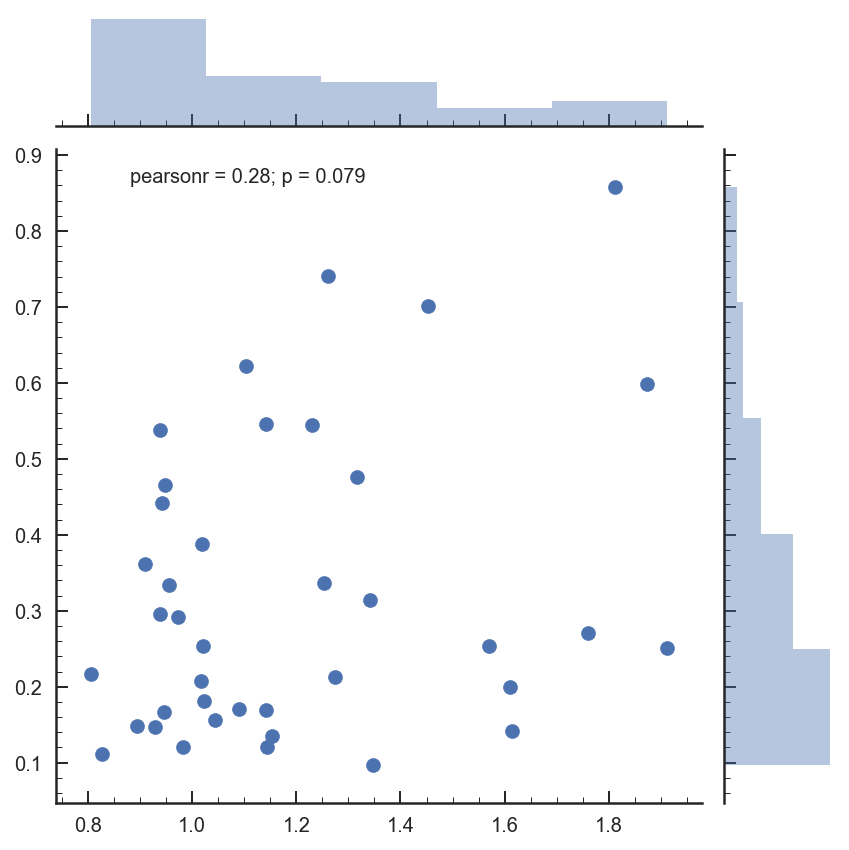

In [138]:
sea.jointplot(rshift[Reff < 2],Reff[Reff < 2])
